# Initialization Experiments

Here we examine the reproducibility of our initial results that FPR gets worse over time by testing many random seeds and creating boxplots for initial and updated FPR

In [9]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from utils import eval_model, perturb_labels_fp, update_model_online_feedback, make_gaussian_data

%matplotlib inline

## `sklearn.datasets.make_classification` Data | num_features=2

In [2]:
seeds = np.arange(1000)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model = update_model_online_feedback(model, x_update, y_update, 100)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

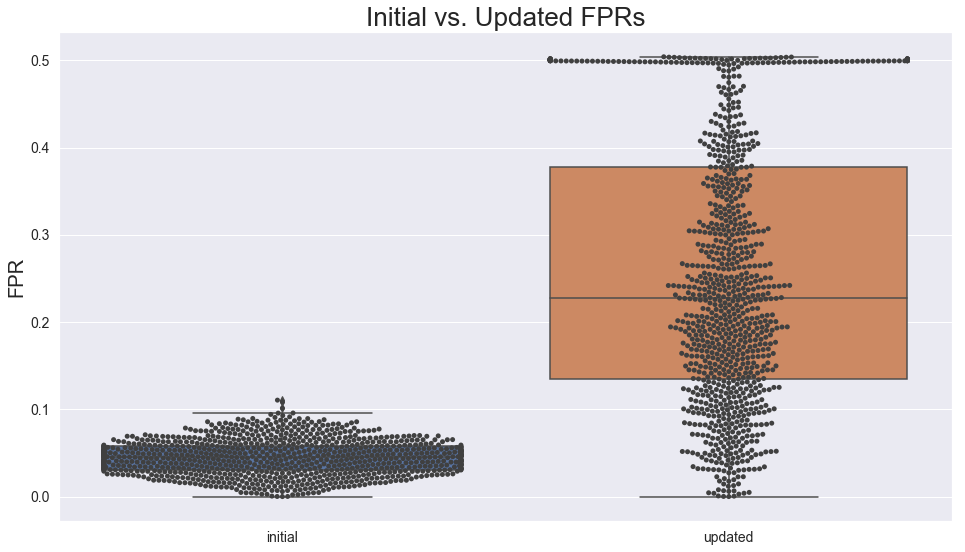

In [3]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

In [4]:
arr_init = np.array(initial_fprs)
arr_updated = np.array(updated_fprs)

In [5]:
differences = arr_updated - arr_init

Text(0.5, 1.0, 'Distribution of (Updated - Initial) FPRs')

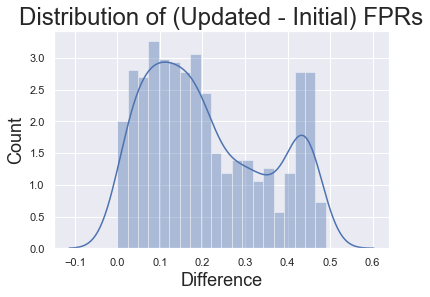

In [6]:
ax = sns.distplot(differences, bins=20)
ax.set_xlabel("Difference", size=18)
ax.set_ylabel("Count", size=18)
ax.set_title("Distribution of (Updated - Initial) FPRs", size=24)

In [10]:
print(pearsonr(initial_fprs, updated_fprs))
print(spearmanr(initial_fprs, updated_fprs))

(0.5210356707586821, 1.1042898676323016e-70)
SpearmanrResult(correlation=0.544396166492465, pvalue=3.097576788637738e-78)


## Gaussian Data | num_features = 2

In [12]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

n = 10000

p0 = 0.5
p1 = 1 - p0

n_features = 2

In [13]:
seeds = np.arange(100)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x_train, y_train = make_gaussian_data(m0 - 0.2, m1 - 0.1, s0, s1, n, p0, p1, features=n_features)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, 45000, p0, p1, features=n_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, 45000, p0, p1, features=n_features)
    
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model = update_model_online_feedback(model, x_update, y_update, 100)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

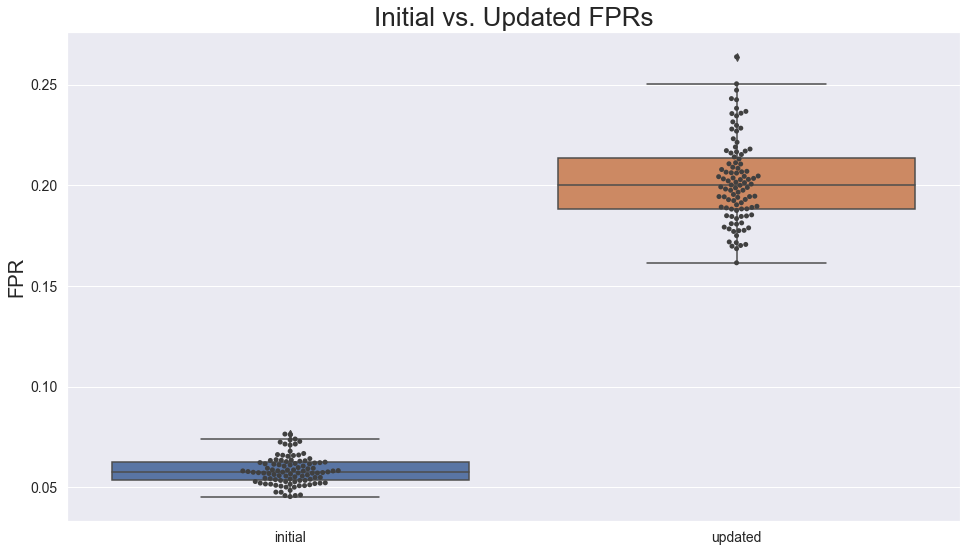

In [14]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)